# MCMC using backward filtering, forward guiding

Parameter inference for trees with Gaussian transitions along edges and observations at the leaf nodes. The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this examples.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax.random import PRNGKey, split
import hyperiax
import jax
from jax import numpy as jnp
from hyperiax.execution import LevelwiseTreeExecutor
from hyperiax.models import DownLambda, UpDownLambda
from hyperiax.models.functional import sum_fuse_children
from hyperiax.tree.updaters import update_noise_inplace
from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

import matplotlib.pyplot as plt
from tqdm import tqdm


In [3]:
key = PRNGKey(42)

# Gaussian tree, constant node covariance

First, we initialize the tree. We let the data be vectors in $\mathbb{R}^2$, and we set the root to be $(0,0)$.

In [4]:
# create tree and initialize with noise
tree = hyperiax.tree.builders.symmetric_tree(2,10)
print('Tree:',tree)

# set edge lengths on all nodes
edge_length = 1.
tree['edge_length'] = edge_length

# data dimension
d = 2

# root value
root = jnp.zeros(d)
tree.root['value'] = root

Tree: HypTree with 3 levels and 111 nodes


We then define parameters for the Gaussian transition kernel.

In [5]:
# parameters, variance and observation noise
params = ParameterStore({
    'variance': VarianceParameter(.5), # variance of the Gaussian transition kernel 
    'obs_var': VarianceParameter(.01) # observation noise variance
    })

Now follows the down transitions. At first, we define the unconditional transitions, which are just Gaussian samples. The covariance is the identity in $\mathbb{R}^d$ times the variance parameter times edge lengths.

In [6]:
# batched version of down_unconditional. The b index refers to the batch, the first axis of W. Alternatively, jax.vmap can be used to vectorize the function, see the down_conditional function below as an example
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    var = params['variance']*edge_length # total edge variance

    return {'value': parent_value+jnp.einsum('b,ij,bj->bi',jnp.sqrt(var),jnp.eye(d),noise)}
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = LevelwiseTreeExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [7]:
subkey, key = split(key)
noise_tree = hyperiax.tree.initializers.initialize_noise(tree, subkey, (d,))
dtree = down_unconditional.down(noise_tree,params.values())

Add noise to leaves.

In [8]:
# copy the sampled tree and add noise to leaf nodes
leaf_tree = dtree.copy()
for node in leaf_tree.iter_leaves():
    key, subkey = split(key)
    node['value'] += jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,node['value'].shape) # add observation noise

Plot a generated tree.

Text(0.5, 1.0, 'Sampled tree without leaf noise')

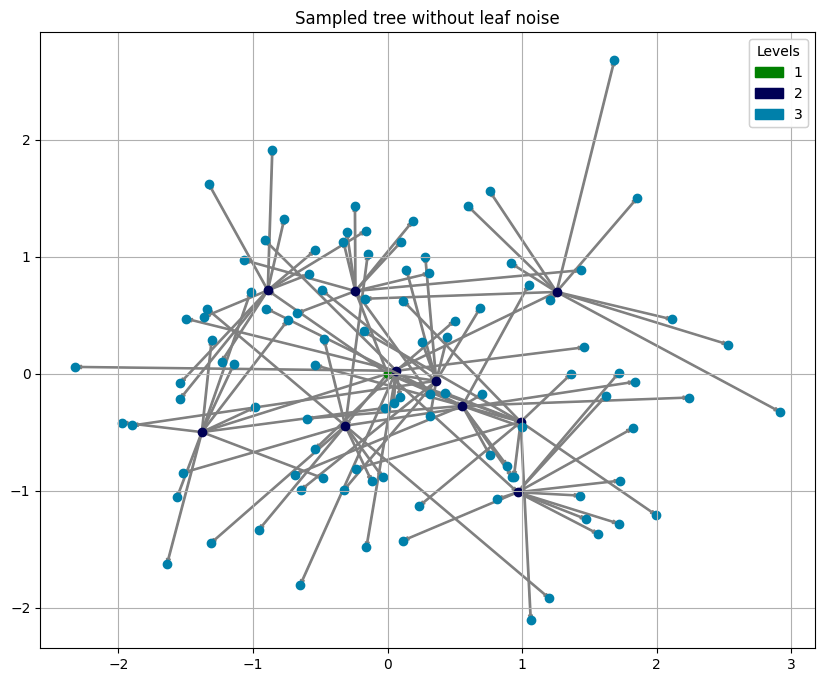

In [9]:
dtree.plot_tree_2d(selector=lambda z: z['value'])
plt.gca().set_title('Sampled tree without leaf noise')

Text(0.5, 1.0, 'Sampled tree with leaf noise')

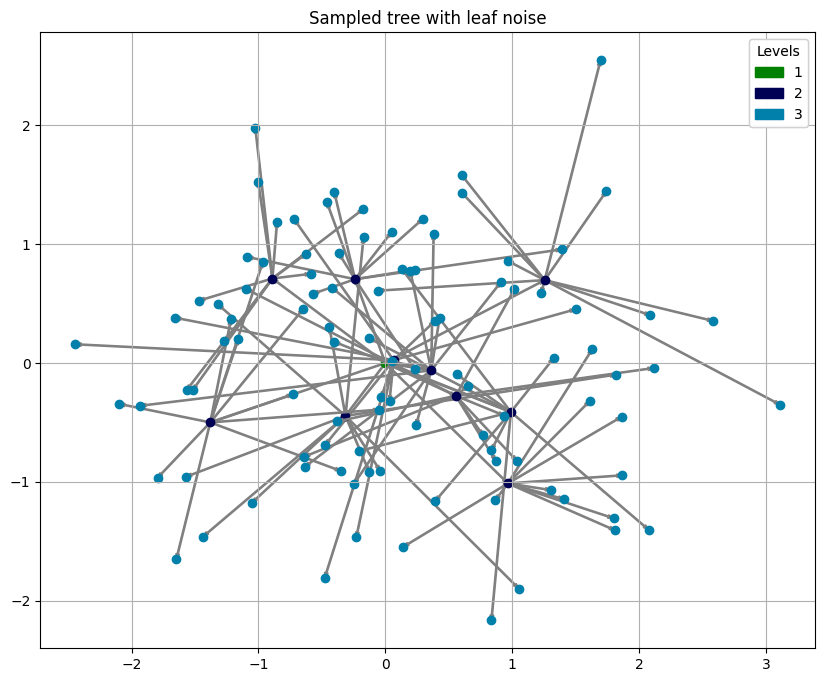

In [10]:
# plot a generated tree
leaf_tree.plot_tree_2d(selector=lambda z: z['value'])
plt.gca().set_title('Sampled tree with leaf noise')

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [11]:
# backwards filter
@jax.jit
def up(noise,edge_length,F_T,H_T,params,**args):
    def f(noise,edge_length,F_T,H_T):
        T = edge_length # edge length, we here used T using the analogy to the continuous case where T denotes the evaluation time of a Brownian motion
        var = T*params['variance'] # total edge variance
        covar = var*jnp.eye(d) # covariance matrix

        Sigma_T = jnp.linalg.inv(H_T)
        v_T = Sigma_T@F_T
    
        invPhi_0 = (jnp.eye(d)+H_T*covar)
        Sigma_0 = Sigma_T@invPhi_0 # = Sigma_T+covar
        H_0 = jnp.linalg.inv(Sigma_0)
        F_0 = jnp.linalg.solve(invPhi_0,F_T)
        v_0 = Sigma_0@F_0
        c_0 = -jax.scipy.stats.multivariate_normal.logpdf(v_0,jnp.zeros(d),Sigma_0)
    
        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0, 'F_T': F_T, 'H_T': H_T}
    return jax.vmap(f)(noise,edge_length,F_T,H_T)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [12]:
# initialize tree for up
def init_up(tree,params):
    for node in tree.iter_bfs():
        if node.children and node.parent:
            del node.data['value']
        else:
            v = node['value']
            Sigma = params['obs_var'].value*jnp.eye(d)
            H = jnp.eye(d)/params['obs_var'].value
            F = H@v
            c = -jax.scipy.stats.multivariate_normal.logpdf(v,jnp.zeros(d),Sigma)
            node.data = {**node.data, 'F_T': F, 'H_T': H}

We can now define the conditional downwards pass, i.e. the forwards guiding.

In [13]:
@jax.jit
def down_conditional(noise,edge_length,F_T,H_T,parent_value,params,**args):
    def f(noise,edge_length,F_T,H_T,parent_value):
        T = edge_length # edge length 
        x = parent_value
        var = T*params['variance'] # total edge variance
        covar = var*jnp.eye(d) # covariance matrix

        invSigma = jnp.linalg.inv(covar)
        H = H_T+invSigma
        mu = jnp.linalg.solve(H,F_T+invSigma@x)
        return {'value': mu+jnp.linalg.solve(jax.scipy.linalg.sqrtm(H),noise)}

    return jax.vmap(f)(noise,edge_length,F_T,H_T,parent_value)

We create the model and executor for the backwards filter (up) and forwards guiding (down).

In [14]:
# create model and executor
updownmodel = UpDownLambda(up_fn=up,fuse_fn=sum_fuse_children(axis=0),down_fn=down_conditional)
updown = LevelwiseTreeExecutor(updownmodel)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [15]:
# backwards filter and fowards guiding
utree = leaf_tree.copy()
init_up(utree,params)
utree = updown.up(utree,params.values())
utree.root['value'] = root
dtree_conditional = updown.down(utree,params.values())

# time the operations
subkey, key = split(key)
noise_tree = hyperiax.tree.initializers.initialize_noise(tree, subkey, (d,))
%time down_unconditional.down(noise_tree,params.values())
%time updown.up(utree,params.values())
updown.up(utree,params.values())
%time updown.up(utree,params.values())

CPU times: user 15.5 ms, sys: 16 µs, total: 15.5 ms
Wall time: 15.6 ms
CPU times: user 53.8 ms, sys: 104 µs, total: 53.9 ms
Wall time: 54 ms
CPU times: user 56.5 ms, sys: 316 µs, total: 56.8 ms
Wall time: 57.1 ms


HypTree with 3 levels and 111 nodes

We test the setup by sampling a number of trees and computing mean and covariance of the leaf data.

In [16]:
# do statistics on the leaf values
leaves = jnp.array([n['value'] for n in dtree.iter_leaves()])
c = utree.root['c_0']; F = utree.root['F_0']; H = utree.root['H_0']
print("root conditional mean vs. sample mean:",jnp.linalg.solve(H,F),jnp.mean(leaves,0))
print("root conditional cov vs. sample cov:",jnp.linalg.inv(H),jnp.cov(leaves.T))

# sample statistics
K = 500 # number samples
samples = jnp.zeros((K,len(list(dtree.iter_leaves())),d))

# sample new noise
update_noise = lambda tree,key: update_noise_inplace(lambda node,new: new,tree,key)

for i in tqdm(range(K)):
    subkey, key = split(key)
    update_noise(noise_tree,subkey)
    dtree = down_unconditional.down(noise_tree,params.values())
    # collect values
    samples = samples.at[i].set(jnp.array([n.data['value'] for n in dtree.iter_leaves()]))
    # add observation noise
    subkey,key = jax.random.split(key)
    samples = samples.at[i].set(samples[i]+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,samples[i].shape))
# print sample statistics for all leaves
print("leaves: ")
for i in range(samples.shape[1]):
    print("mean: ",jnp.mean(samples[:,i],0))
    print("cov: ",jnp.cov(samples[:,i].T))

root conditional mean vs. sample mean: [ 0.09738673 -0.00083045] [0.09919202 0.0021711 ]
root conditional cov vs. sample cov: [[0.05010001 0.        ]
 [0.         0.05010001]] [[ 1.3106731  -0.06423577]
 [-0.06423577  0.92455775]]


100%|██████████| 500/500 [00:12<00:00, 40.85it/s]


leaves: 
mean:  [-0.05713913 -0.00130815]
cov:  [[0.9411862  0.05478512]
 [0.05478512 0.93353033]]
mean:  [-0.08041071 -0.00026792]
cov:  [[ 1.053729   -0.06069357]
 [-0.06069357  1.1042464 ]]
mean:  [-0.0677387  -0.04850235]
cov:  [[ 1.0172836  -0.10140079]
 [-0.10140079  0.99935544]]
mean:  [-0.02564184 -0.05595004]
cov:  [[ 0.92180604 -0.0704352 ]
 [-0.0704352   1.0608145 ]]
mean:  [-0.00870211  0.02005514]
cov:  [[1.0051632  0.04623511]
 [0.04623511 0.8848379 ]]
mean:  [-0.01368126  0.00371344]
cov:  [[ 0.9643866  -0.07337838]
 [-0.07337838  0.9188617 ]]
mean:  [-0.00948242  0.08102757]
cov:  [[ 0.9191396  -0.01126194]
 [-0.01126194  1.0996273 ]]
mean:  [ 0.0056792  -0.02660248]
cov:  [[ 0.9178602  -0.02021996]
 [-0.02021996  0.95244986]]
mean:  [-0.05428185 -0.02783349]
cov:  [[ 0.9926122  -0.02113349]
 [-0.02113349  0.893554  ]]
mean:  [-0.031556   -0.04208039]
cov:  [[ 1.0314754  -0.04628864]
 [-0.04628864  0.99321234]]
mean:  [-0.0504706   0.03858215]
cov:  [[ 1.0595971  -0.103

# MCMC

We make two MCMC runs: First, we use that the model with constant node covariance is fully Gaussian and we can read the data likelihood directly from the results of upwards pass. Subsequently, we also sample the state of the tree to get a likelihood approximation from the conditional downwards pass. This version is not necessary in the current model, but it points towards how inference in non-Gaussian models (e.g. non-linear diffusion processes along the edges) will look.

Initial parameters:  {'variance': 0.25, 'obs_var': 0.01}
data parameters:  {'variance': 0.5, 'obs_var': 0.01}


100%|██████████| 400/400 [00:40<00:00,  9.84it/s]


Acceptance rate: 0.8725


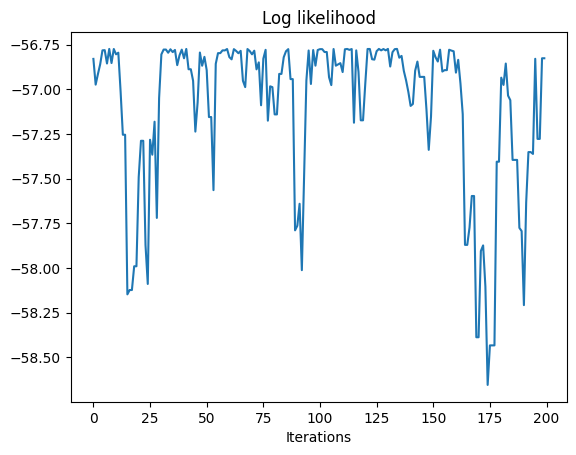

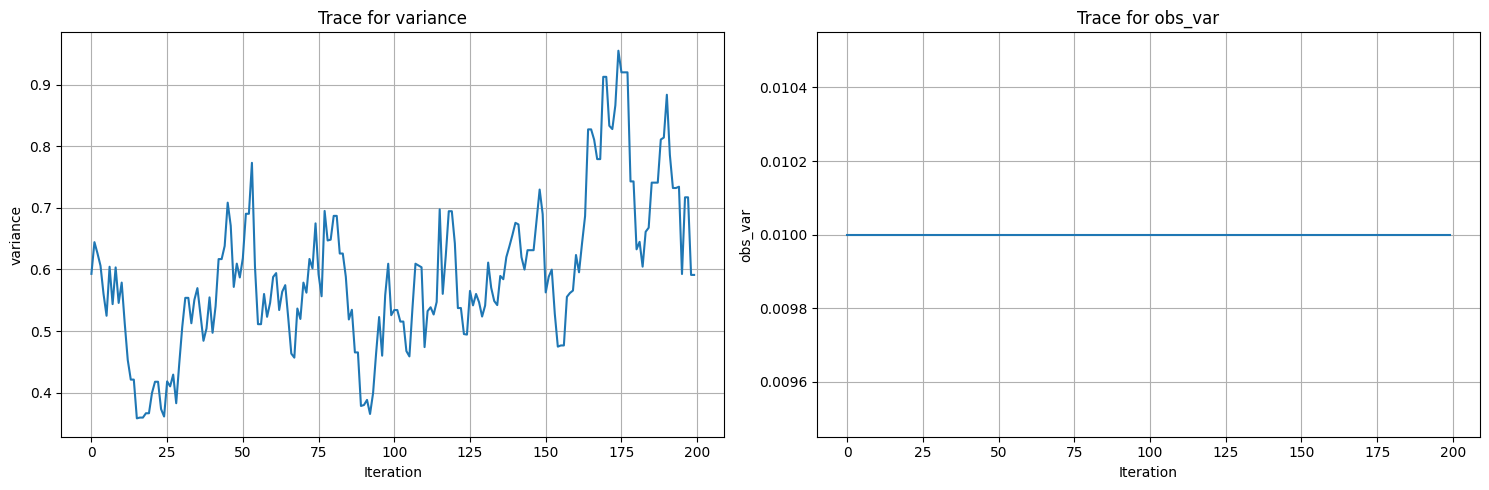

In [17]:
# inference for Gaussian model, likelihood from backwards filtering
def log_likelihood(state):
    """Log likelihood of the tree."""
    parameters,tree = state
    v,c,F,H = tree.root['value'],tree.root['c_0'],tree.root['F_0'],tree.root['H_0']
    return -c+F@v-.5*v.T@H@v

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(state)
    return log_prior + log_like

def proposal(data, state, key):
    parameters,tree = state

    new_parameters = parameters.propose(key)
    # backwards filtering with updated parameters
    utree = data.copy(); init_up(utree,new_parameters)
    utree = updown.up(utree,new_parameters.values())

    return new_parameters,utree

# tree values and parameters
init_params = ParameterStore({
    'variance': VarianceParameter(.25), # variance of the Gaussian transition kernel 
    'obs_var': VarianceParameter(.01,alpha=3,beta=.5,keep_constant=True) # observation noise variance. We keep it constant here because of lacking identifiability (which will not be the case with higher-dimensional correlated data)
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
leaf_tree.root['value'] = root
utree = leaf_tree.copy(); init_up(utree,init_params)
init_state = (init_params,updown.up(utree,init_params.values()))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods,samples = metropolis_hastings(log_posterior, proposal, leaf_tree, init_state, 200, burn_in=200, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples)

Initial parameters:  {'variance': 0.25, 'obs_var': 0.01}
data parameters:  {'variance': 0.5, 'obs_var': 0.01}


100%|██████████| 400/400 [01:57<00:00,  3.40it/s]

Acceptance rate: 0.5675



/Users/stefan/projects/hyperiax/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/stefan/projects/hyperiax/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


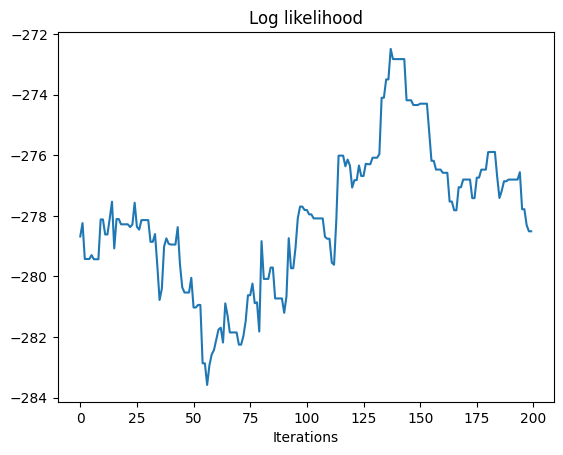

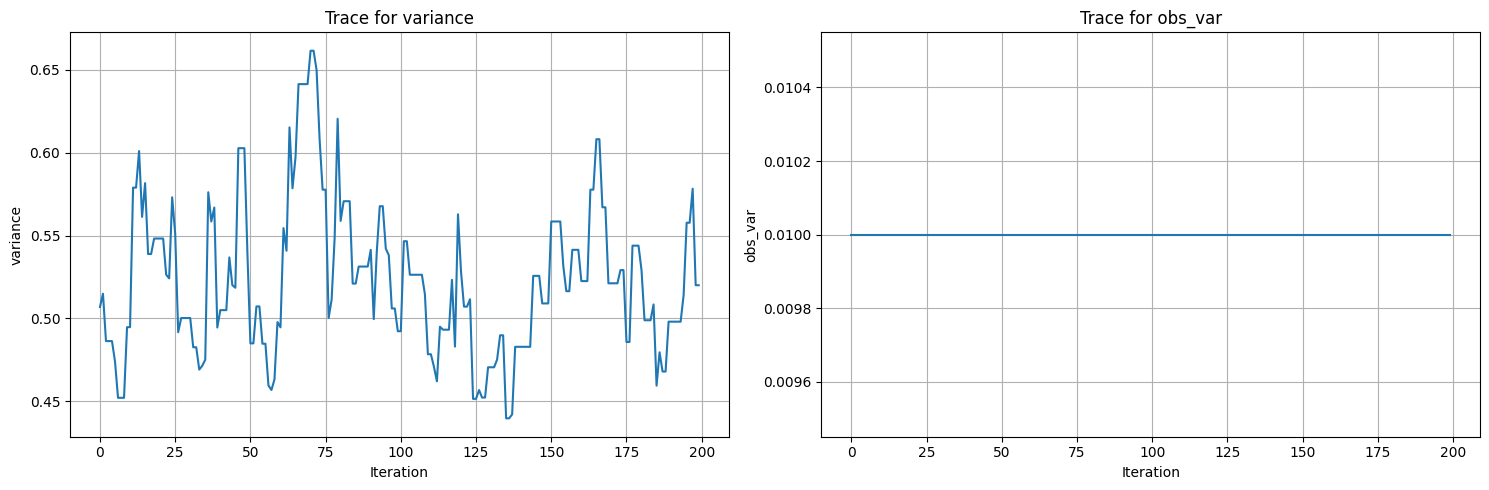

In [18]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = lambda node: .9
update_CN = lambda tree,key: update_noise_inplace(lambda node,new: node['noise']*lambd(node)+jnp.sqrt((1-lambd(node)**2))*new,tree,key)
zero_noise = lambda tree,key: update_noise_inplace(lambda node,new: jnp.zeros_like(node['noise']),tree,key)

# downwards pass to compute likelihoods
@jax.jit
def down_log_likelihood(value,edge_length,parent_value,params,**args):
    var = params['variance']*edge_length # total edge variance
    covar = jnp.einsum('b,ij->bij',var,jnp.eye(d)) # covariance matrix

    return {'log_likelihood': jax.vmap(lambda value,m,covar: jnp.real(jax.scipy.stats.multivariate_normal.logpdf(value,m,covar)))(value,parent_value,covar)}
downmodel_log_likelihood = DownLambda(down_fn=down_log_likelihood)
down_log_likelihood = LevelwiseTreeExecutor(downmodel_log_likelihood)

# log likelihood of the tree
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,tree = state
    log_likelihood_tree = down_log_likelihood.down(tree,params.values())
    log_likelihood_tree.root['log_likelihood'] = 0
    tree_log_likelihood = jnp.sum(jnp.array([n['log_likelihood'] for n in log_likelihood_tree.iter_bfs()]))
    residuals = jnp.array([sample['value']-obs['value'] for sample,obs in zip(tree.iter_leaves(),data.iter_leaves())]) 
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,tree = state

    # new tree with the leaf data
    utree = tree.copy(); 
    for data_leaf,utree_leaf in zip(data.iter_leaves(),utree.iter_leaves()):
        utree_leaf['value'] = data_leaf['value']

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # backwards filtering with updated parameters
    init_up(utree,new_parameters)
    utree = updown.up(utree,new_parameters.values())

    # update tree, CN update and forward filtering with the updated noise
    utree_CN = update_CN(utree,subkeys[1])
    dtree = updown.down(utree_CN,new_parameters.values())

    return new_parameters,dtree

# tree values and parameters
init_params = ParameterStore({
    'variance': VarianceParameter(.25), # variance of the Gaussian transition kernel 
    'obs_var': VarianceParameter(.01,alpha=3,beta=.5,keep_constant=True) # observation noise variance
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
leaf_tree.root['value'] = root
leaf_tree = zero_noise(leaf_tree,key)
utree = leaf_tree.copy(); init_up(utree,init_params);
init_state = (init_params,updown.down(updown.up(utree,init_params.values()),init_params.values()))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_tree, init_state, 200, burn_in=200, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples)